In [1]:
# LIBRARIES
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # Visualization
import seaborn as sb # Visualization
import PIL #Image viewer

# import glob to return all file paths that match a specific pattern
import os
from glob import glob

# for Compatibility
from __future__ import print_function, division
from builtins import range, input

# Include tensorflow keras layers, models, and preprocessing
# Preprocessing is important for VGG as the orginal authors didnt
# normalize the data
from tensorflow import keras 
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Importing confusion matrix to describe the performance of the model
from sklearn.metrics import confusion_matrix

In [2]:
# Include the directories of the dataset
train_path = '../VGG/archive/fruits-360-original-size/fruits-360-original-size/Training'
valid_path = '../VGG/archive/fruits-360-original-size/fruits-360-original-size/Validation'

In [3]:
# Get the files from the directories
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')
folders = glob(train_path + '/*')

In [4]:
# Check the length of training data
print(len(image_files))

6231


In [5]:
# Check the length of validation data
print(len(valid_image_files))

3114


In [6]:
# Check the number of classes
print(len(folders))

24


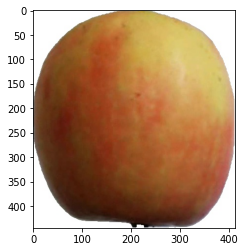

In [7]:
# View a sample image
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [8]:
# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

In [9]:
# training config:
epochs = 10
batch_size = 32

In [10]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [11]:
# if you don't want to train existing weights, set False
# set True to Fine tune
for layer in vgg.layers:
  layer.trainable = False

In [12]:
# Adding the last layer corresponding to the number of classes.
# Use Softmax for multiclass classifcation
# More hidden layers can be added
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [13]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [14]:
# view the structure of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)      

In [15]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

How does ImageDataGenerator works!!

In [16]:
# Create an instance of ImageDataGenerator

gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

In [17]:
test_gen = gen.flow_from_directory(valid_path, target_size = IMAGE_SIZE)
print(test_gen.class_indices)

Found 3114 images belonging to 24 classes.
{'apple_6': 0, 'apple_braeburn_1': 1, 'apple_crimson_snow_1': 2, 'apple_golden_1': 3, 'apple_golden_2': 4, 'apple_golden_3': 5, 'apple_granny_smith_1': 6, 'apple_hit_1': 7, 'apple_pink_lady_1': 8, 'apple_red_1': 9, 'apple_red_2': 10, 'apple_red_3': 11, 'apple_red_delicios_1': 12, 'apple_red_yellow_1': 13, 'apple_rotten_1': 14, 'cabbage_white_1': 15, 'carrot_1': 16, 'cucumber_1': 17, 'cucumber_3': 18, 'eggplant_violet_1': 19, 'pear_1': 20, 'pear_3': 21, 'zucchini_1': 22, 'zucchini_dark_1': 23}


In [18]:
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

In [19]:
labels

['apple_6',
 'apple_braeburn_1',
 'apple_crimson_snow_1',
 'apple_golden_1',
 'apple_golden_2',
 'apple_golden_3',
 'apple_granny_smith_1',
 'apple_hit_1',
 'apple_pink_lady_1',
 'apple_red_1',
 'apple_red_2',
 'apple_red_3',
 'apple_red_delicios_1',
 'apple_red_yellow_1',
 'apple_rotten_1',
 'cabbage_white_1',
 'carrot_1',
 'cucumber_1',
 'cucumber_3',
 'eggplant_violet_1',
 'pear_1',
 'pear_3',
 'zucchini_1',
 'zucchini_dark_1']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -97.47355 max: 151.061


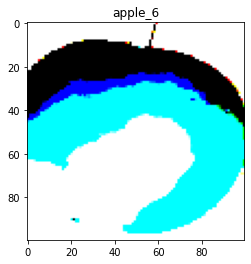

In [20]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [21]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.


In [22]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/10
194/194 [==============================] - 112s 577ms/step - loss: 3.4486 - accuracy: 0.7761 - val_loss: 1.4381 - val_accuracy: 0.8869
Epoch 2/10
194/194 [==============================] - 113s 580ms/step - loss: 0.8494 - accuracy: 0.9268 - val_loss: 0.9620 - val_accuracy: 0.9288
Epoch 3/10
194/194 [==============================] - 115s 591ms/step - loss: 0.5030 - accuracy: 0.9527 - val_loss: 0.4415 - val_accuracy: 0.9568
Epoch 4/10
194/194 [==============================] - 114s 587ms/step - loss: 0.4282 - accuracy: 0.9634 - val_loss: 1.4015 - val_accuracy: 0.9336
Epoch 5/10
194/194 [==============================] - 111s 573ms/step - loss: 0.4349 - accuracy: 0.9655 - val_loss: 0.2551 - val_accuracy: 0.9758
Epoch 6/10
194/194 [==============================] - 113s 584ms/step - loss: 0.2986 - accuracy: 0.9737 - val_loss: 0.2080 - val_accuracy: 0.9803
Epoch 7/10
194/194 [==============================] - 115s 592ms/step - loss: 0.2651 - accuracy: 0.9789 - val_loss: 0.2688 -

In [24]:
def get_confusion_matrix(data_path, N):
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break

    cm = confusion_matrix(targets, predictions)
    return cm

In [25]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 6231
Found 6231 images belonging to 24 classes.
50
[[313   0   0   0   1   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 305   5   0   0   0   1   0   3   5   1   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 316   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 308   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 300   8   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   4 311   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   1   3 316   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   1   0   0 467   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   4   0   0   0   0   0 309   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   

In [26]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 3114
Found 3114 images belonging to 24 classes.
[[158   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 158   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 159   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 154   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   1 152   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 157   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   1 159   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 233   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0 155   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0  

Confusion matrix, without normalization
[[313   0   0   0   1   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 305   5   0   0   0   1   0   3   5   1   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 316   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 308   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 300   8   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   4 311   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   1   3 316   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   1   0   0 467   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   4   0   0   0   0   0 309   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 308   0   1  

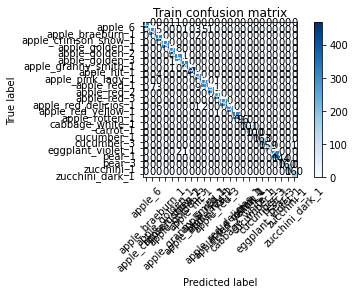

In [28]:
from utils import plot_confusion_matrix
plot_confusion_matrix(cm, labels, title='Train confusion matrix')

Confusion matrix, without normalization
[[158   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 158   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 159   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 154   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   1 152   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 157   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   1 159   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 233   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0 155   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 155   0   0  

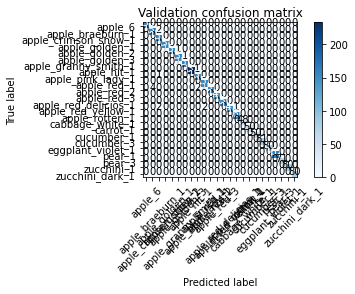

In [29]:
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

In [41]:
r.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [42]:
score = r.model.evaluate(valid_generator)

98/98 [==============================] - 38s 385ms/step - loss: 0.1329 - accuracy: 0.9888


In [43]:
score

[0.1328911930322647, 0.9887604117393494]

In [44]:
print(f"Model Accuracy: %{score[1]*100}")

Model Accuracy: %98.87604117393494


In [45]:
r.model.save("./")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./assets
